In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc
)
from sklearn.model_selection import KFold, cross_validate

sns.set_theme(style='whitegrid')

# EDA

# Phase 1: The First Look

In [2]:
df = pd.read_csv("heart.csv")

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
print(df.shape)
print(df.info())

(1025, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None


In [4]:
# What are the min/max values (for spotting outliers)? Are the mean and median (50%) far apart (which indicates skew)?

print(df.describe())

               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000  

In [5]:
print(f"Total duplicated rows: {df.duplicated().sum()}")
df[df.duplicated(keep=False)].sort_values(df.columns.tolist())

Total duplicated rows: 723


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
60,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
64,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
118,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
668,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
12,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,76,0,2,140,197,0,2,116,0,1.1,1,0,2,1
965,76,0,2,140,197,0,2,116,0,1.1,1,0,2,1
160,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0
162,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0


In [6]:
df = df.drop_duplicates()
print(df.shape)

(302, 14)


In [7]:
categorical_cols = [col for col in df.columns if df[col].nunique() <= 10]

print(f"Categorical columns: {categorical_cols}\n")
for col in categorical_cols:
    print("Value counts:")
    print(df[col].value_counts())

Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

Value counts:
sex
1    206
0     96
Name: count, dtype: int64
Value counts:
cp
0    143
2     86
1     50
3     23
Name: count, dtype: int64
Value counts:
fbs
0    257
1     45
Name: count, dtype: int64
Value counts:
restecg
1    151
0    147
2      4
Name: count, dtype: int64
Value counts:
exang
0    203
1     99
Name: count, dtype: int64
Value counts:
slope
2    141
1    140
0     21
Name: count, dtype: int64
Value counts:
ca
0    175
1     65
2     38
3     20
4      4
Name: count, dtype: int64
Value counts:
thal
2    165
3    117
1     18
0      2
Name: count, dtype: int64
Value counts:
target
1    164
0    138
Name: count, dtype: int64


# Phase 2: Univariate Analysis

Categorical: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
Numeric: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

--- Plotting Numeric Features ---



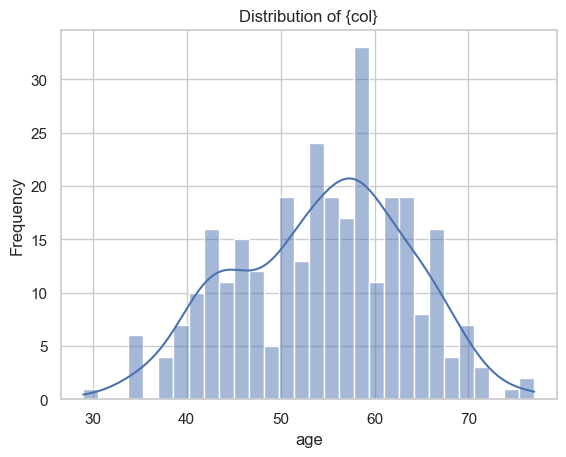

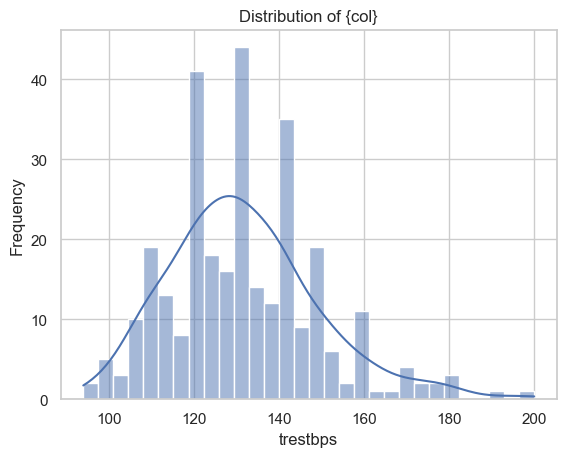

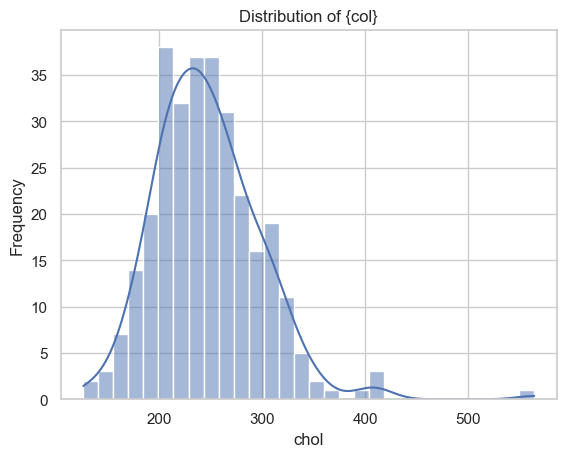

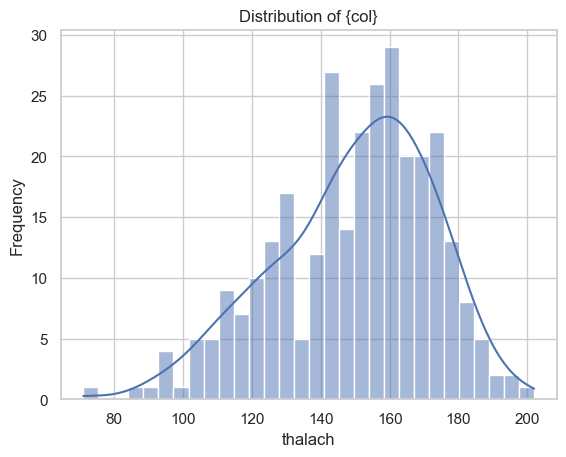

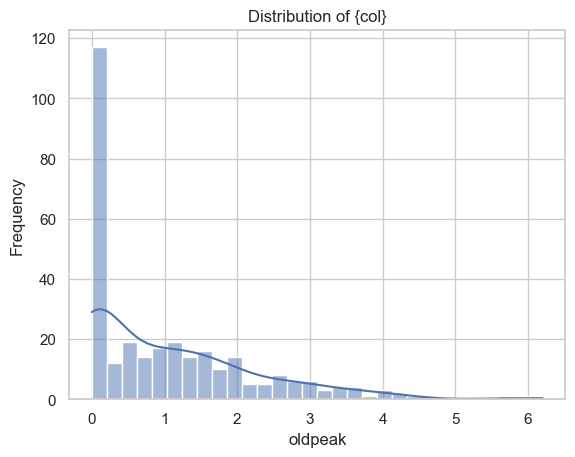

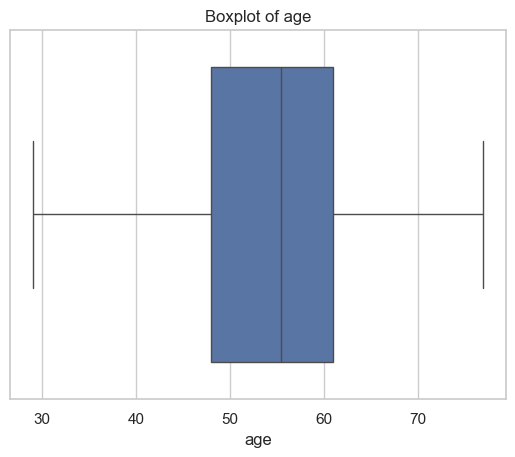

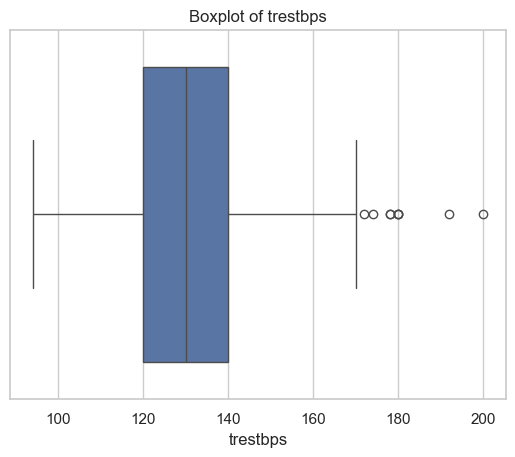

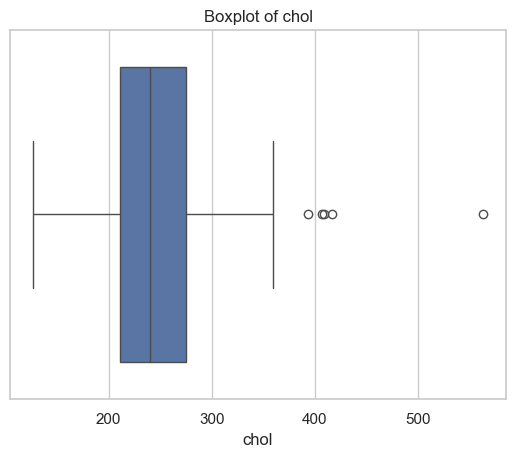

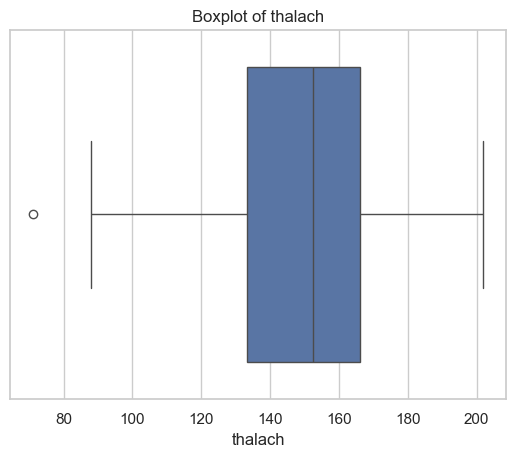

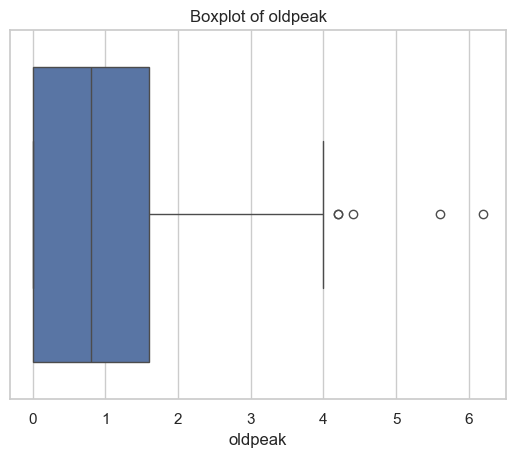


--- Plotting Categorical Features ---



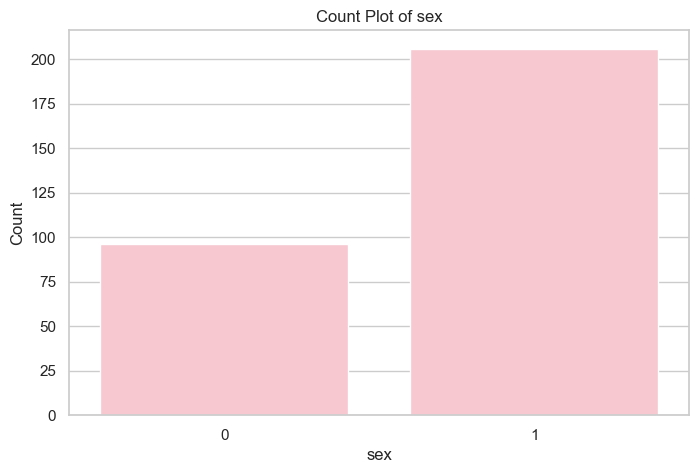

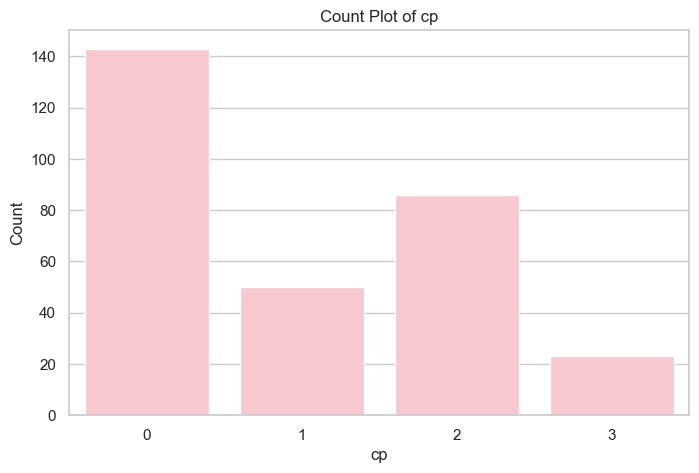

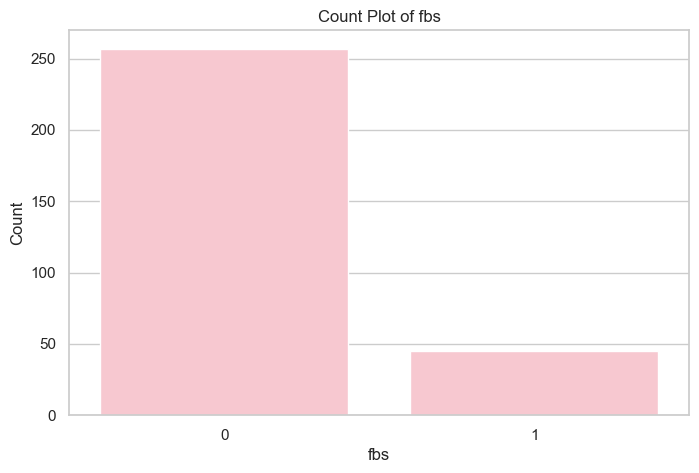

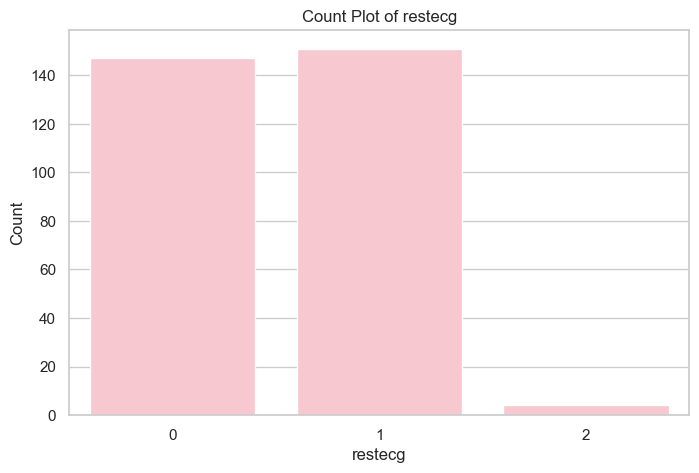

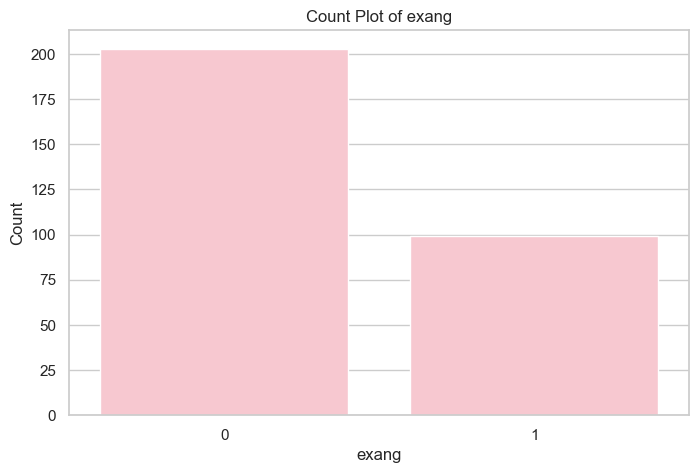

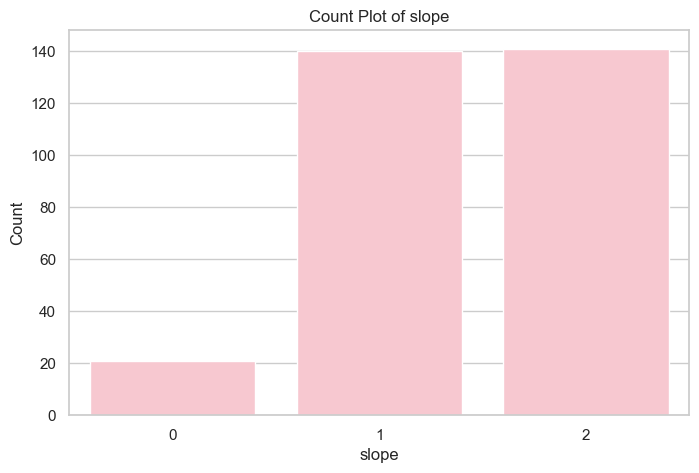

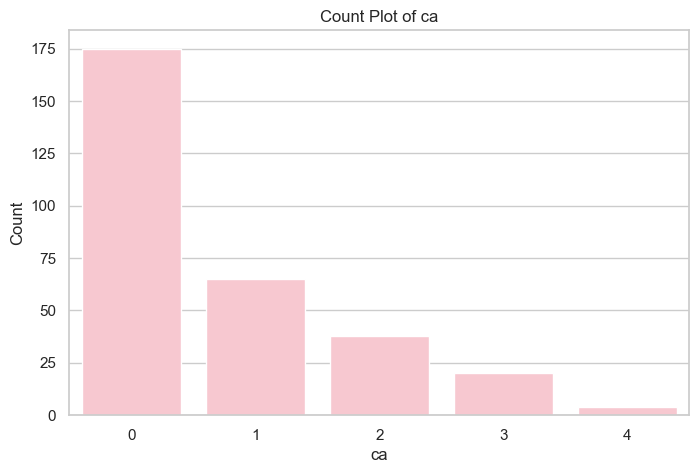

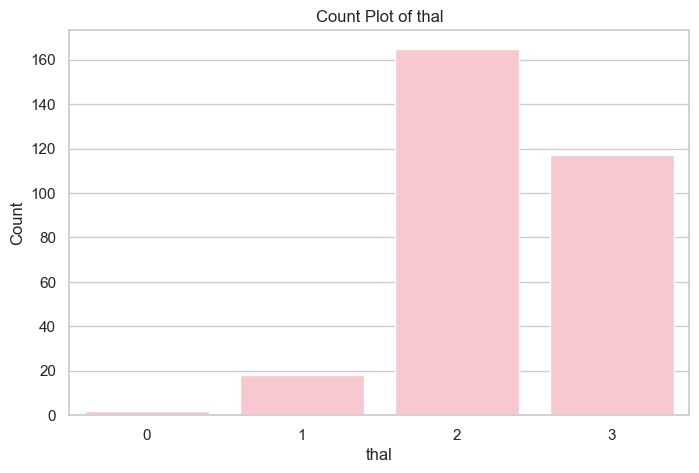

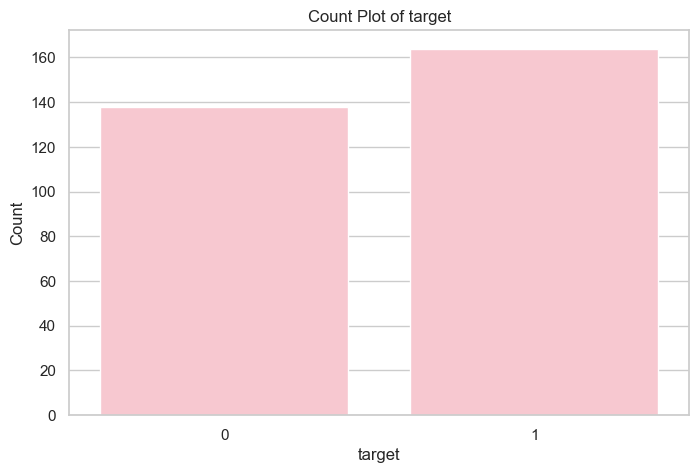

In [8]:
categorical_cols = [col for col in df.columns if df[col].nunique() <= 10]
numeric_cols = [col for col in df.columns if col not in categorical_cols]

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)
print('\n--- Plotting Numeric Features ---\n')

for col in numeric_cols:
    plt.Figure()
    sns.histplot(df[col], kde=True, bins=30)
    plt.title('Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in numeric_cols:
    plt.Figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

print("\n--- Plotting Categorical Features ---\n")

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col], color='pink')
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Heatmap


Correlation Matrix:
               age  trestbps      chol   thalach   oldpeak
age       1.000000  0.283121  0.207216 -0.395235  0.206040
trestbps  0.283121  1.000000  0.125256 -0.048023  0.194600
chol      0.207216  0.125256  1.000000 -0.005308  0.050086
thalach  -0.395235 -0.048023 -0.005308  1.000000 -0.342201
oldpeak   0.206040  0.194600  0.050086 -0.342201  1.000000


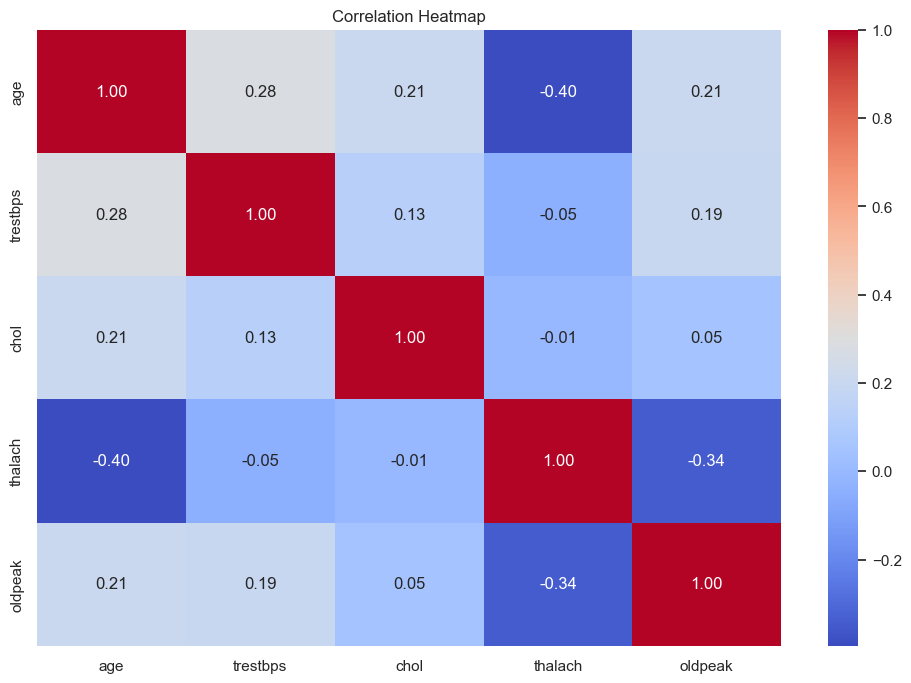


Correlation Matrix (Numeric + Target):
               age  trestbps      chol   thalach   oldpeak    target
age       1.000000  0.283121  0.207216 -0.395235  0.206040 -0.221476
trestbps  0.283121  1.000000  0.125256 -0.048023  0.194600 -0.146269
chol      0.207216  0.125256  1.000000 -0.005308  0.050086 -0.081437
thalach  -0.395235 -0.048023 -0.005308  1.000000 -0.342201  0.419955
oldpeak   0.206040  0.194600  0.050086 -0.342201  1.000000 -0.429146
target   -0.221476 -0.146269 -0.081437  0.419955 -0.429146  1.000000


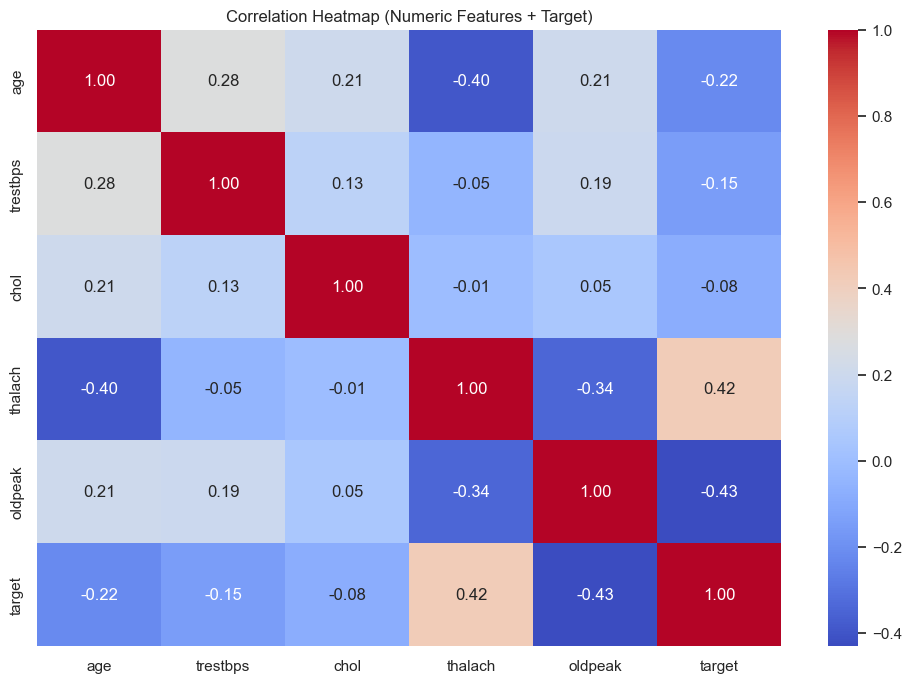

In [9]:
corr_matrix = df[numeric_cols].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


cols_for_corr = numeric_cols + ['target']
corr_matrix = df[cols_for_corr].corr()
print("\nCorrelation Matrix (Numeric + Target):")
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Features + Target)')
plt.show()



# Data Preprocessing

In [10]:
df.iloc[0].isnull()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
Name: 0, dtype: bool

### Train/Test Split

In [11]:
print("--- Phase 1: Setup and Data Splitting ---")

TARGET = 'target'
FEATURES = [c for c in df.columns if c != TARGET]
X = df[FEATURES].copy()
y = df[TARGET].copy()

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}\n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")


--- Phase 1: Setup and Data Splitting ---
Features (X) shape: (302, 13)
Target (y) shape: (302,)

X_train shape: (241, 13)
X_test shape: (61, 13)



In [12]:
print("--- Phase 2: Building the Preprocessing Pipelines ---")

# Numerical columns
normal_cols = ['age', 'thalach']             # normal → StandardScaler
skewed_cols = ['chol', 'oldpeak']            # skewed → PowerTransformer + StandardScaler
robust_cols = ['trestbps']                   # has outliers → RobustScaler

# Categorical columns
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Pipelines for numerical features
normal_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

skewed_pipeline = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

robust_pipeline = Pipeline([
    ('robust', RobustScaler())
])

# Pipeline for categorical features
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

--- Phase 2: Building the Preprocessing Pipelines ---


In [13]:
print("--- Phase 3: Combining Pipelines with ColumnTransformer ---")

# Combine all pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('normal', normal_pipeline, normal_cols),
        ('skewed', skewed_pipeline, skewed_cols),
        ('robust', robust_pipeline, robust_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='drop'
)

--- Phase 3: Combining Pipelines with ColumnTransformer ---


In [14]:
print("--- Phase 4: Fitting and Transforming the Data ---")

# --- Fit on Training Data ---
print("Fitting preprocessor on X_train...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
print("...Done.\n")

# --- Transform Test Data ---
print("Transforming X_test...")
X_test_preprocessed = preprocessor.transform(X_test)
print("...Done.\n")


print(f"Original X_train shape: {X_train.shape}")
print(f"Preprocessed X_train shape: {X_train_preprocessed.shape}")
print(f"Preprocessed X_test shape: {X_test_preprocessed.shape}")


--- Phase 4: Fitting and Transforming the Data ---
Fitting preprocessor on X_train...
...Done.

Transforming X_test...
...Done.

Original X_train shape: (241, 13)
Preprocessed X_train shape: (241, 30)
Preprocessed X_test shape: (61, 30)


In [15]:
print("\n--- Phase 5: Inspecting the Preprocessed Output ---")

feature_names = preprocessor.get_feature_names_out()
print(f"Total {len(feature_names)} features after preprocessing:")
print(list(feature_names))

df_train_preprocessed = pd.DataFrame(
    X_train_preprocessed, 
    columns=feature_names, 
    index=X_train.index
)

print("\nHead of preprocessed training data:")
print(df_train_preprocessed.head())

print("\nDescriptive stats of preprocessed training data:")
print(df_train_preprocessed.describe().round(2))


--- Phase 5: Inspecting the Preprocessed Output ---
Total 30 features after preprocessing:
['normal__age', 'normal__thalach', 'skewed__chol', 'skewed__oldpeak', 'robust__trestbps', 'cat__sex_0', 'cat__sex_1', 'cat__cp_0', 'cat__cp_1', 'cat__cp_2', 'cat__cp_3', 'cat__fbs_0', 'cat__fbs_1', 'cat__restecg_0', 'cat__restecg_1', 'cat__restecg_2', 'cat__exang_0', 'cat__exang_1', 'cat__slope_0', 'cat__slope_1', 'cat__slope_2', 'cat__ca_0', 'cat__ca_1', 'cat__ca_2', 'cat__ca_3', 'cat__ca_4', 'cat__thal_0', 'cat__thal_1', 'cat__thal_2', 'cat__thal_3']

Head of preprocessed training data:
     normal__age  normal__thalach  skewed__chol  skewed__oldpeak  \
158     1.421944         0.408240      3.890787         0.877935   
199    -0.465841        -1.104705     -0.910875         0.333002   
479     0.422528        -0.882213     -0.539023         1.186395   
460     1.644036        -0.214737      0.235806         1.094585   
169    -1.021072        -0.570724     -2.003227        -1.157505   

     

# Modeling

In [16]:
print("--- Practical Step 3: Build (pipeline + preprocessor) ---")

pipelines = {
    "LogisticRegression": Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegression(random_state=42 ,max_iter=2000))
    ]),
    "LDA": Pipeline([
        ("preprocess", preprocessor),
        ("model", LinearDiscriminantAnalysis())
    ]),
    "QDA": Pipeline([
        ("preprocess", preprocessor),
        ("model", QuadraticDiscriminantAnalysis(reg_param=0.01))
    ]),
    "NaiveBayes": Pipeline([
        ("preprocess", preprocessor),
        ("model", GaussianNB())
    ]),
    "KNN": Pipeline([
        ("preprocess", preprocessor),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]),
    "DecisionTree": Pipeline([
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(random_state=42))
    ]),
    "SVM": Pipeline([
        ("preprocess", preprocessor),
        ("model", SVC(probability=True))
    ]),
}


--- Practical Step 3: Build (pipeline + preprocessor) ---


In [17]:
print("--- Practical Step 4: Fit Models on Train ---")

trained_models = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    trained_models[name] = pipe
    print(f"{name} fitted successfully.")


--- Practical Step 4: Fit Models on Train ---
LogisticRegression fitted successfully.
LDA fitted successfully.
QDA fitted successfully.
NaiveBayes fitted successfully.
KNN fitted successfully.
DecisionTree fitted successfully.
RandomForest fitted successfully.
SVM fitted successfully.


In [18]:
print("--- Practical Step 5: Predictions on Test set ---\n")

y_pred = {}
y_proba = {}

for name, model in trained_models.items():
    # ---Prediction ---
    y_pred[name] = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_proba[name] = model.predict_proba(X_test)[:, 1]
    else:
        y_proba[name] = None

    # --- Example Predictions ---
    print(f"\n=== {name} — Example Predictions (first 20 rows) ===")
    example_df = pd.DataFrame({
        "Actual": y_test.values[:20],
        "Predicted": y_pred[name][:20]
    })
    
    if y_proba[name] is not None:
        example_df["Predicted_Probability"] = y_proba[name][:20]
    
    print(example_df)


--- Practical Step 5: Predictions on Test set ---


=== LogisticRegression — Example Predictions (first 20 rows) ===
    Actual  Predicted  Predicted_Probability
0        0          0               0.192612
1        0          1               0.520765
2        0          0               0.004224
3        0          1               0.618032
4        0          1               0.950852
5        0          0               0.010422
6        1          1               0.847458
7        0          0               0.092787
8        1          1               0.983297
9        0          0               0.273636
10       1          1               0.940230
11       1          1               0.638497
12       0          1               0.620576
13       1          1               0.952971
14       1          0               0.092183
15       1          1               0.947591
16       1          1               0.909764
17       1          0               0.058218
18       1          1       

# Evaluation

--- Model Evaluation ---

--- LogisticRegression ---

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.82      0.85      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:


<Figure size 700x600 with 0 Axes>

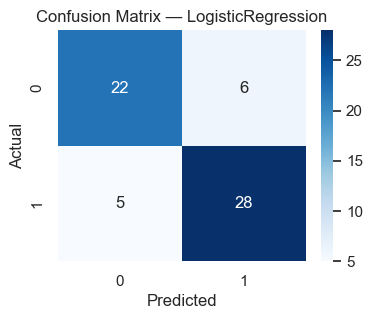

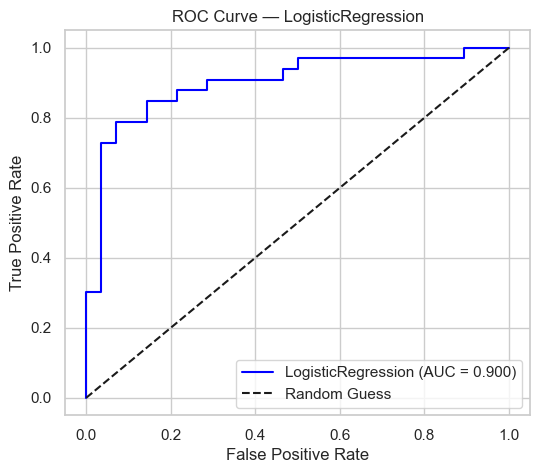

AUC = 0.9004

--- LDA ---

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

Confusion Matrix:


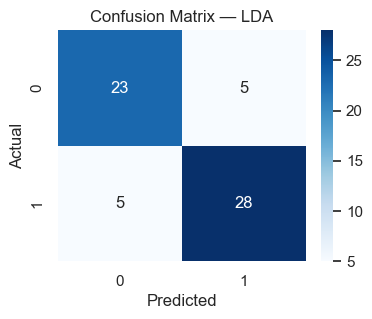

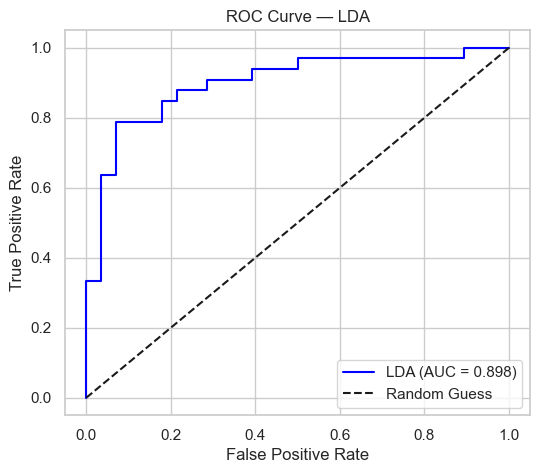

AUC = 0.8983

--- QDA ---

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.77      0.82      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61

Confusion Matrix:


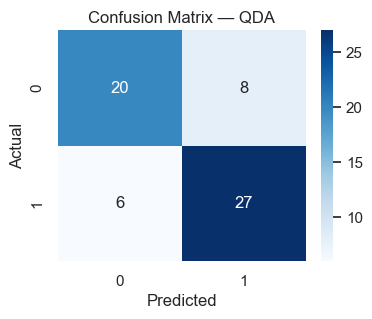

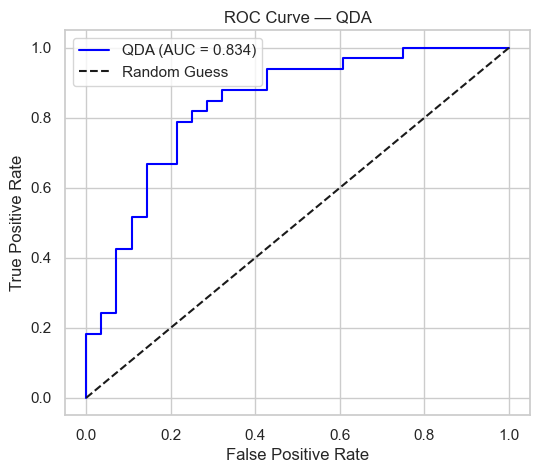

AUC = 0.8344

--- NaiveBayes ---

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.79      0.82      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61

Confusion Matrix:


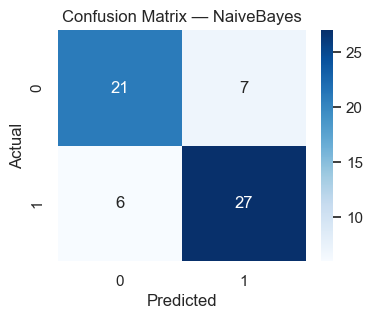

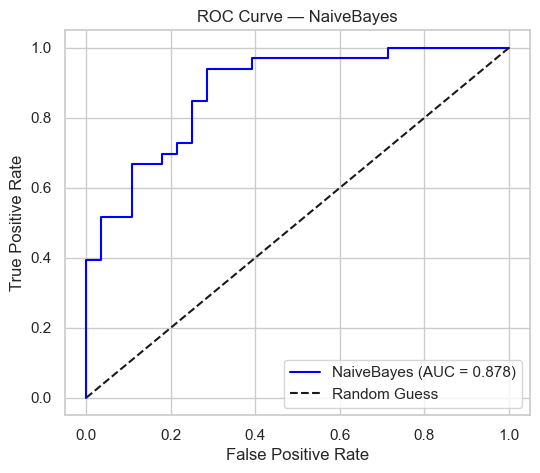

AUC = 0.8777

--- KNN ---

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        28
           1       0.90      0.82      0.86        33

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

Confusion Matrix:


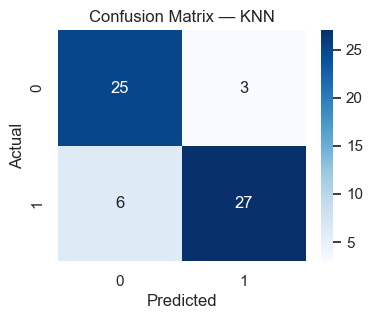

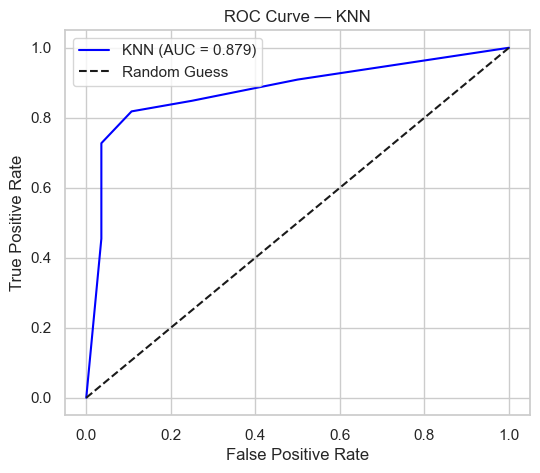

AUC = 0.8793

--- DecisionTree ---

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        28
           1       0.74      0.76      0.75        33

    accuracy                           0.72        61
   macro avg       0.72      0.72      0.72        61
weighted avg       0.72      0.72      0.72        61

Confusion Matrix:


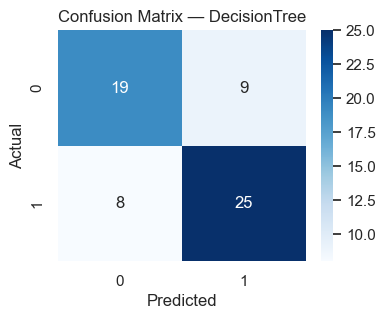

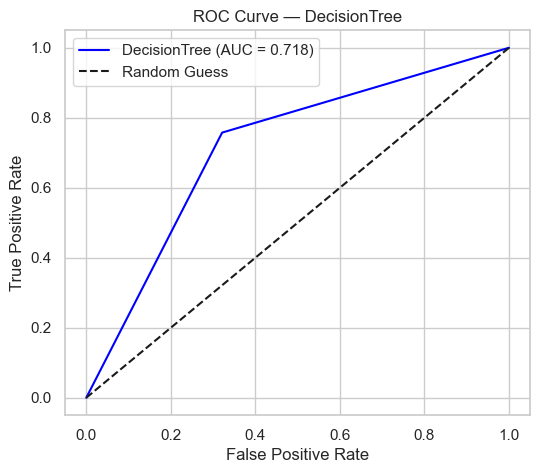

AUC = 0.7181

--- RandomForest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.84      0.82      0.83        33

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:


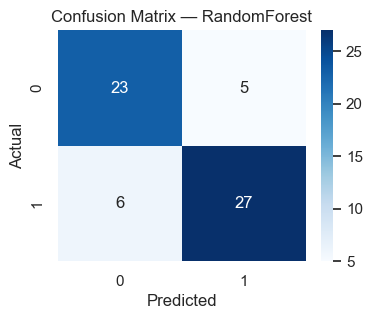

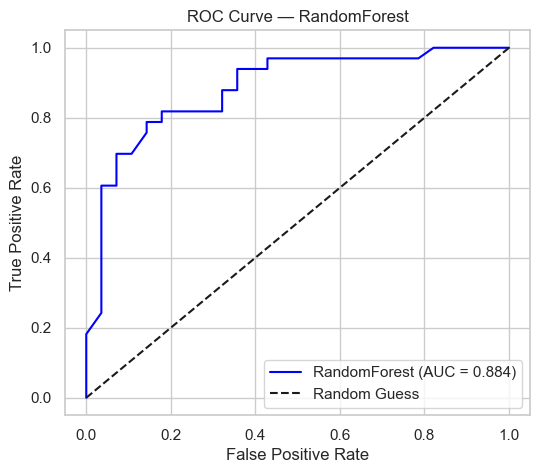

AUC = 0.8837

--- SVM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        28
           1       0.81      0.79      0.80        33

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61

Confusion Matrix:


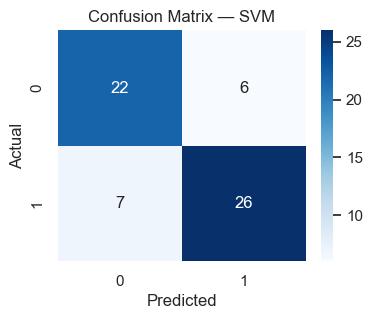

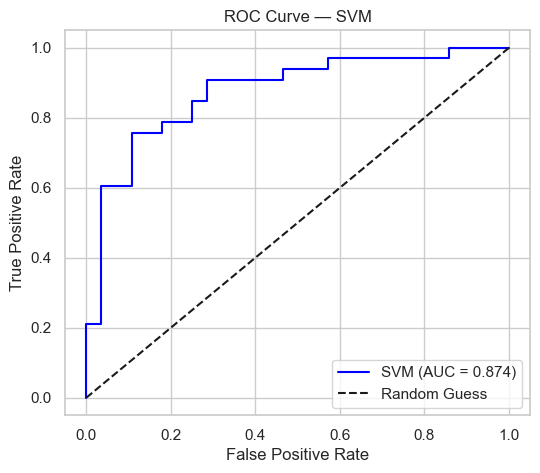

AUC = 0.8745


In [19]:
print("--- Model Evaluation ---")

auc_scores = {}

plt.figure(figsize=(7, 6))

for name, model in trained_models.items():

    print(f"\n--- {name} ---")

    # --- Prediction ---
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        print("Model does not support predict_proba → skipping ROC.")
        y_proba = None

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
   
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)
        auc_scores[name] = auc_score

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})", color='blue')
        plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
        plt.title(f"ROC Curve — {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"AUC = {auc_score:.4f}")



In [20]:
print("\n--- 10-Fold Cross-Validation (Robustness Check) ---\n")

cv_scores = {}
cv_std = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=10, scoring='accuracy')
    cv_scores[name] = scores.mean()
    cv_std[name] = scores.std()
    
    print(f"Model: {name}")
    print(f"  All 10 scores: {np.round(scores, 3)}")
    print(f"  Mean Accuracy: {scores.mean():.3f} (±{scores.std():.3f})")
    print("-" * 30)

print("\nEvaluation complete. You can now compare these results to the basic models.\n")


if len(cv_scores) == 0:
    print("No CV results found. Make sure pipelines, X and y are defined and the loop above ran.")
else:
    best_model = max(cv_scores, key=cv_scores.get)
    print("--- BEST MODEL SELECTED ---")
    print(f"Best Model: {best_model}")
    print(f"Mean Accuracy: {cv_scores[best_model]:.4f}")
    print(f"Std: {cv_std[best_model]:.4f}")


--- 10-Fold Cross-Validation (Robustness Check) ---

Model: LogisticRegression
  All 10 scores: [0.871 0.903 0.867 0.833 0.833 1.    0.8   0.767 0.767 0.867]
  Mean Accuracy: 0.851 (±0.066)
------------------------------
Model: LDA
  All 10 scores: [0.839 0.903 0.833 0.833 0.833 1.    0.767 0.733 0.767 0.8  ]
  Mean Accuracy: 0.831 (±0.073)
------------------------------
Model: QDA
  All 10 scores: [0.806 0.839 0.733 0.867 0.8   0.933 0.7   0.633 0.767 0.833]
  Mean Accuracy: 0.791 (±0.082)
------------------------------
Model: NaiveBayes
  All 10 scores: [0.677 0.903 0.8   0.933 0.9   1.    0.767 0.667 0.767 0.833]
  Mean Accuracy: 0.825 (±0.104)
------------------------------
Model: KNN
  All 10 scores: [0.806 0.903 0.867 0.867 0.8   0.933 0.767 0.8   0.867 0.833]
  Mean Accuracy: 0.844 (±0.049)
------------------------------
Model: DecisionTree
  All 10 scores: [0.806 0.645 0.8   0.667 0.767 0.833 0.733 0.6   0.733 0.767]
  Mean Accuracy: 0.735 (±0.072)
----------------------------

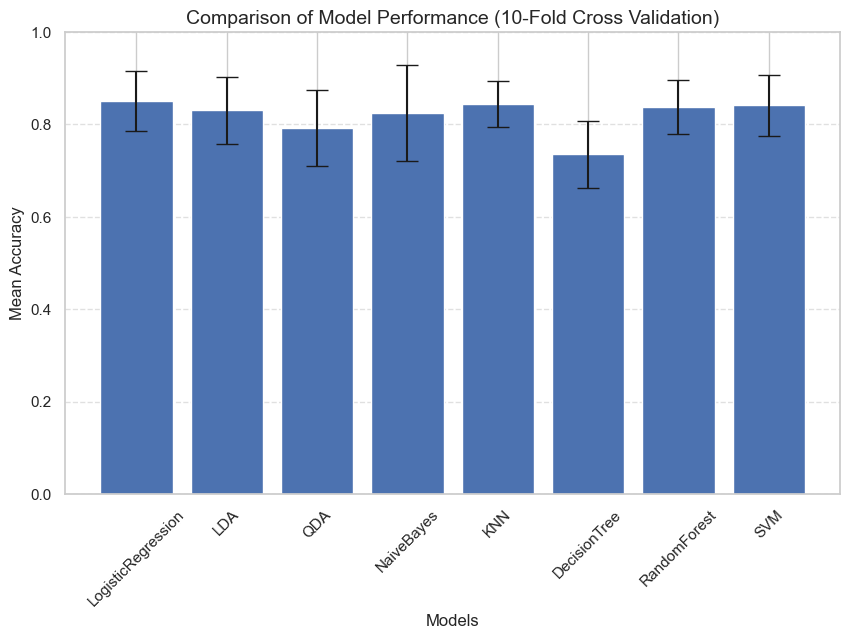

In [21]:
models = list(cv_scores.keys())
scores = list(cv_scores.values())
errors = list(cv_std.values())

plt.figure(figsize=(10, 6))
plt.bar(models, scores, yerr=errors, capsize=8)

plt.title("Comparison of Model Performance (10-Fold Cross Validation)", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0, 1)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


# Hyperparameter Tuning

In [22]:
print("\n--- Hyperparameter Tuning: Logistic Regression ---")

from sklearn.model_selection import GridSearchCV

log_reg_params = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 50, 100],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "liblinear"]
}

log_reg_grid = GridSearchCV(
    estimator=pipelines["LogisticRegression"],
    param_grid=log_reg_params,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)

log_reg_grid.fit(X_train, y_train)

print("\nBest Parameters:", log_reg_grid.best_params_)
print("Best CV Accuracy:", log_reg_grid.best_score_)

# Save best model
best_log_reg = log_reg_grid.best_estimator_



--- Hyperparameter Tuning: Logistic Regression ---

Best Parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV Accuracy: 0.8423333333333334


In [23]:
print("\n--- Hyperparameter Tuning: Random Forest ---")

rf_params = {
    "model__n_estimators": [50, 100, 200, 300],
    "model__max_depth": [None, 3, 5, 7, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=pipelines["RandomForest"],
    param_grid=rf_params,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("\nBest Parameters:", rf_grid.best_params_)
print("Best CV Accuracy:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_



--- Hyperparameter Tuning: Random Forest ---

Best Parameters: {'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV Accuracy: 0.8546666666666667


In [24]:
print("\n--- Hyperparameter Tuning: KNN ---")

knn_params = {
    "model__n_neighbors": list(range(1, 31)),
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan"]
}

knn_grid = GridSearchCV(
    estimator=pipelines["KNN"],
    param_grid=knn_params,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

print("\nBest Parameters:", knn_grid.best_params_)
print("Best CV Accuracy:", knn_grid.best_score_)

best_knn = knn_grid.best_estimator_



--- Hyperparameter Tuning: KNN ---

Best Parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 8, 'model__weights': 'distance'}
Best CV Accuracy: 0.8630000000000001



--- Final Evaluation on Test Set (After Tuning) ---

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



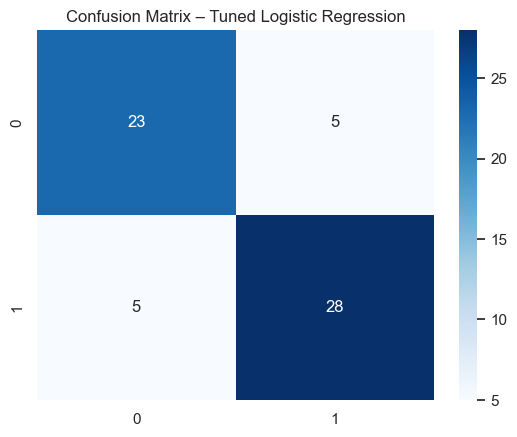

AUC = 0.9048


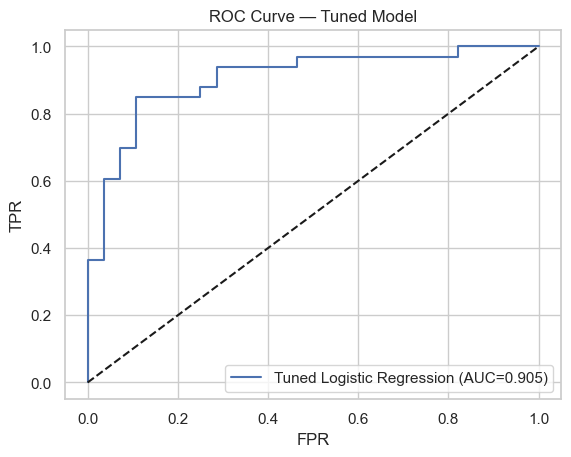

In [25]:
print("\n--- Final Evaluation on Test Set (After Tuning) ---")

y_pred_tuned = best_log_reg.predict(X_test)
y_proba_tuned = best_log_reg.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix – Tuned Logistic Regression")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
auc_score = auc(fpr, tpr)
print(f"AUC = {auc_score:.4f}")

plt.plot(fpr, tpr, label=f"Tuned Logistic Regression (AUC={auc_score:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve — Tuned Model")
plt.legend()
plt.show()
